In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import glob
import os
import geopandas as gpd
from plotnine import *

# Initial Visualization: Time series of Yield

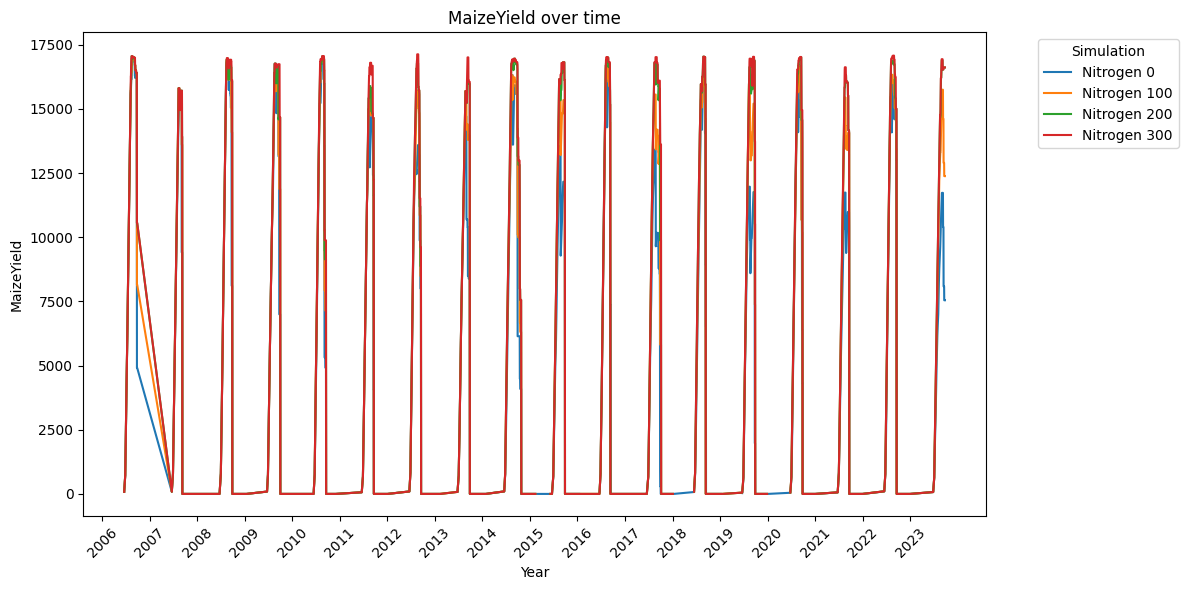

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
import matplotlib.dates as mdates

results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])

possible_vars = ['MaizeYield','SoyBeanYield','Yield','Nitrogen_Sowing']

pivot_df = results.pivot_table(
    index="Clock.Today",
    columns="Nitrogen",
    values='MaizeYield',
    aggfunc="max"
)

plt.figure(figsize=(12, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], label=f"Nitrogen {col}")

# Force all years on x-axis
years = pd.DatetimeIndex(pivot_df.index).year.unique()
plt.xticks(pd.to_datetime([f'{year}-01-01' for year in years]), years, rotation=45)

plt.xlabel("Year")
plt.ylabel('MaizeYield')
plt.title(f"{'MaizeYield'} over time")
plt.legend(title="Simulation", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
import matplotlib.dates as mdates

results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])

possible_vars = ['MaizeYield','SoyBeanYield','Yield','Nitrogen_Sowing']

@interact(variable=possible_vars)
def plot_variable(variable="SurfaceOrganicMatter.Cover"):
    pivot_df = results.pivot_table(
        index="Clock.Today",
        columns="Nitrogen",
        values=variable,
        aggfunc="max"
    )

    plt.figure(figsize=(12, 6))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f"Nitrogen {col}")

    # Force all years on x-axis
    years = pd.DatetimeIndex(pivot_df.index).year.unique()
    plt.xticks(pd.to_datetime([f'{year}-01-01' for year in years]), years, rotation=45)

    plt.xlabel("Year")
    plt.ylabel(variable)
    plt.title(f"{variable} over time")
    plt.legend(title="Simulation", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='variable', options=('MaizeYield', 'SoyBeanYield', 'Yield', 'Nitrog…

# GTD - Ground Truth Data

In [41]:
GTD=pd.read_csv("/workspace/workflow/_6EvaluationNotebooks/GTD.csv")


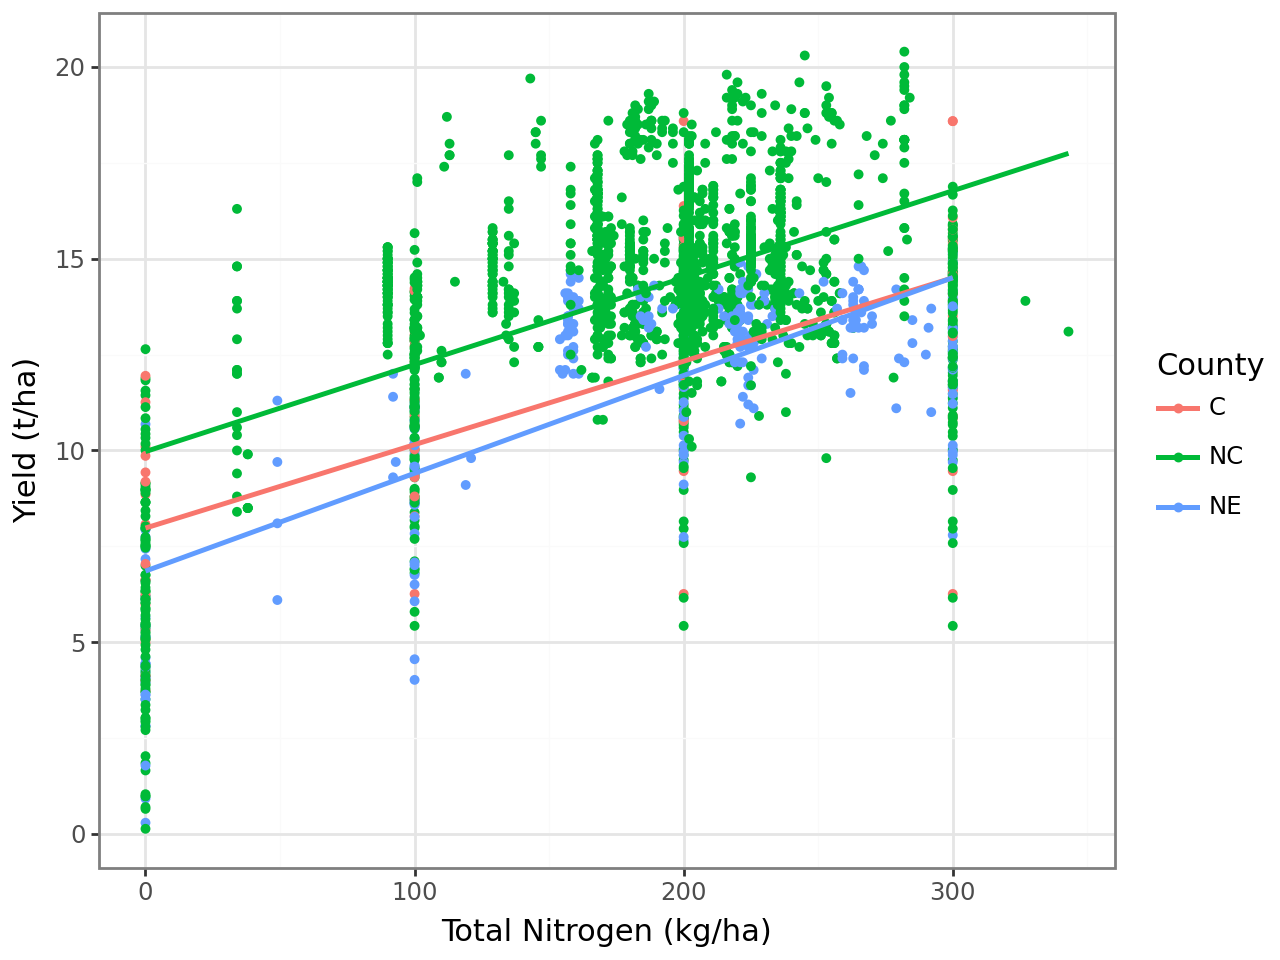

In [3]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_bw

plot = (
    ggplot(GTD, aes(x='NKg_Ha', y='yield_ton', color='region')) +
    geom_point(size=1) +
    geom_smooth(method='lm', se=False) +
    theme_bw() +
    labs(
        x='Total Nitrogen (kg/ha)',
        y='Yield (t/ha)',
        color='County'
    )
)

plot.show()

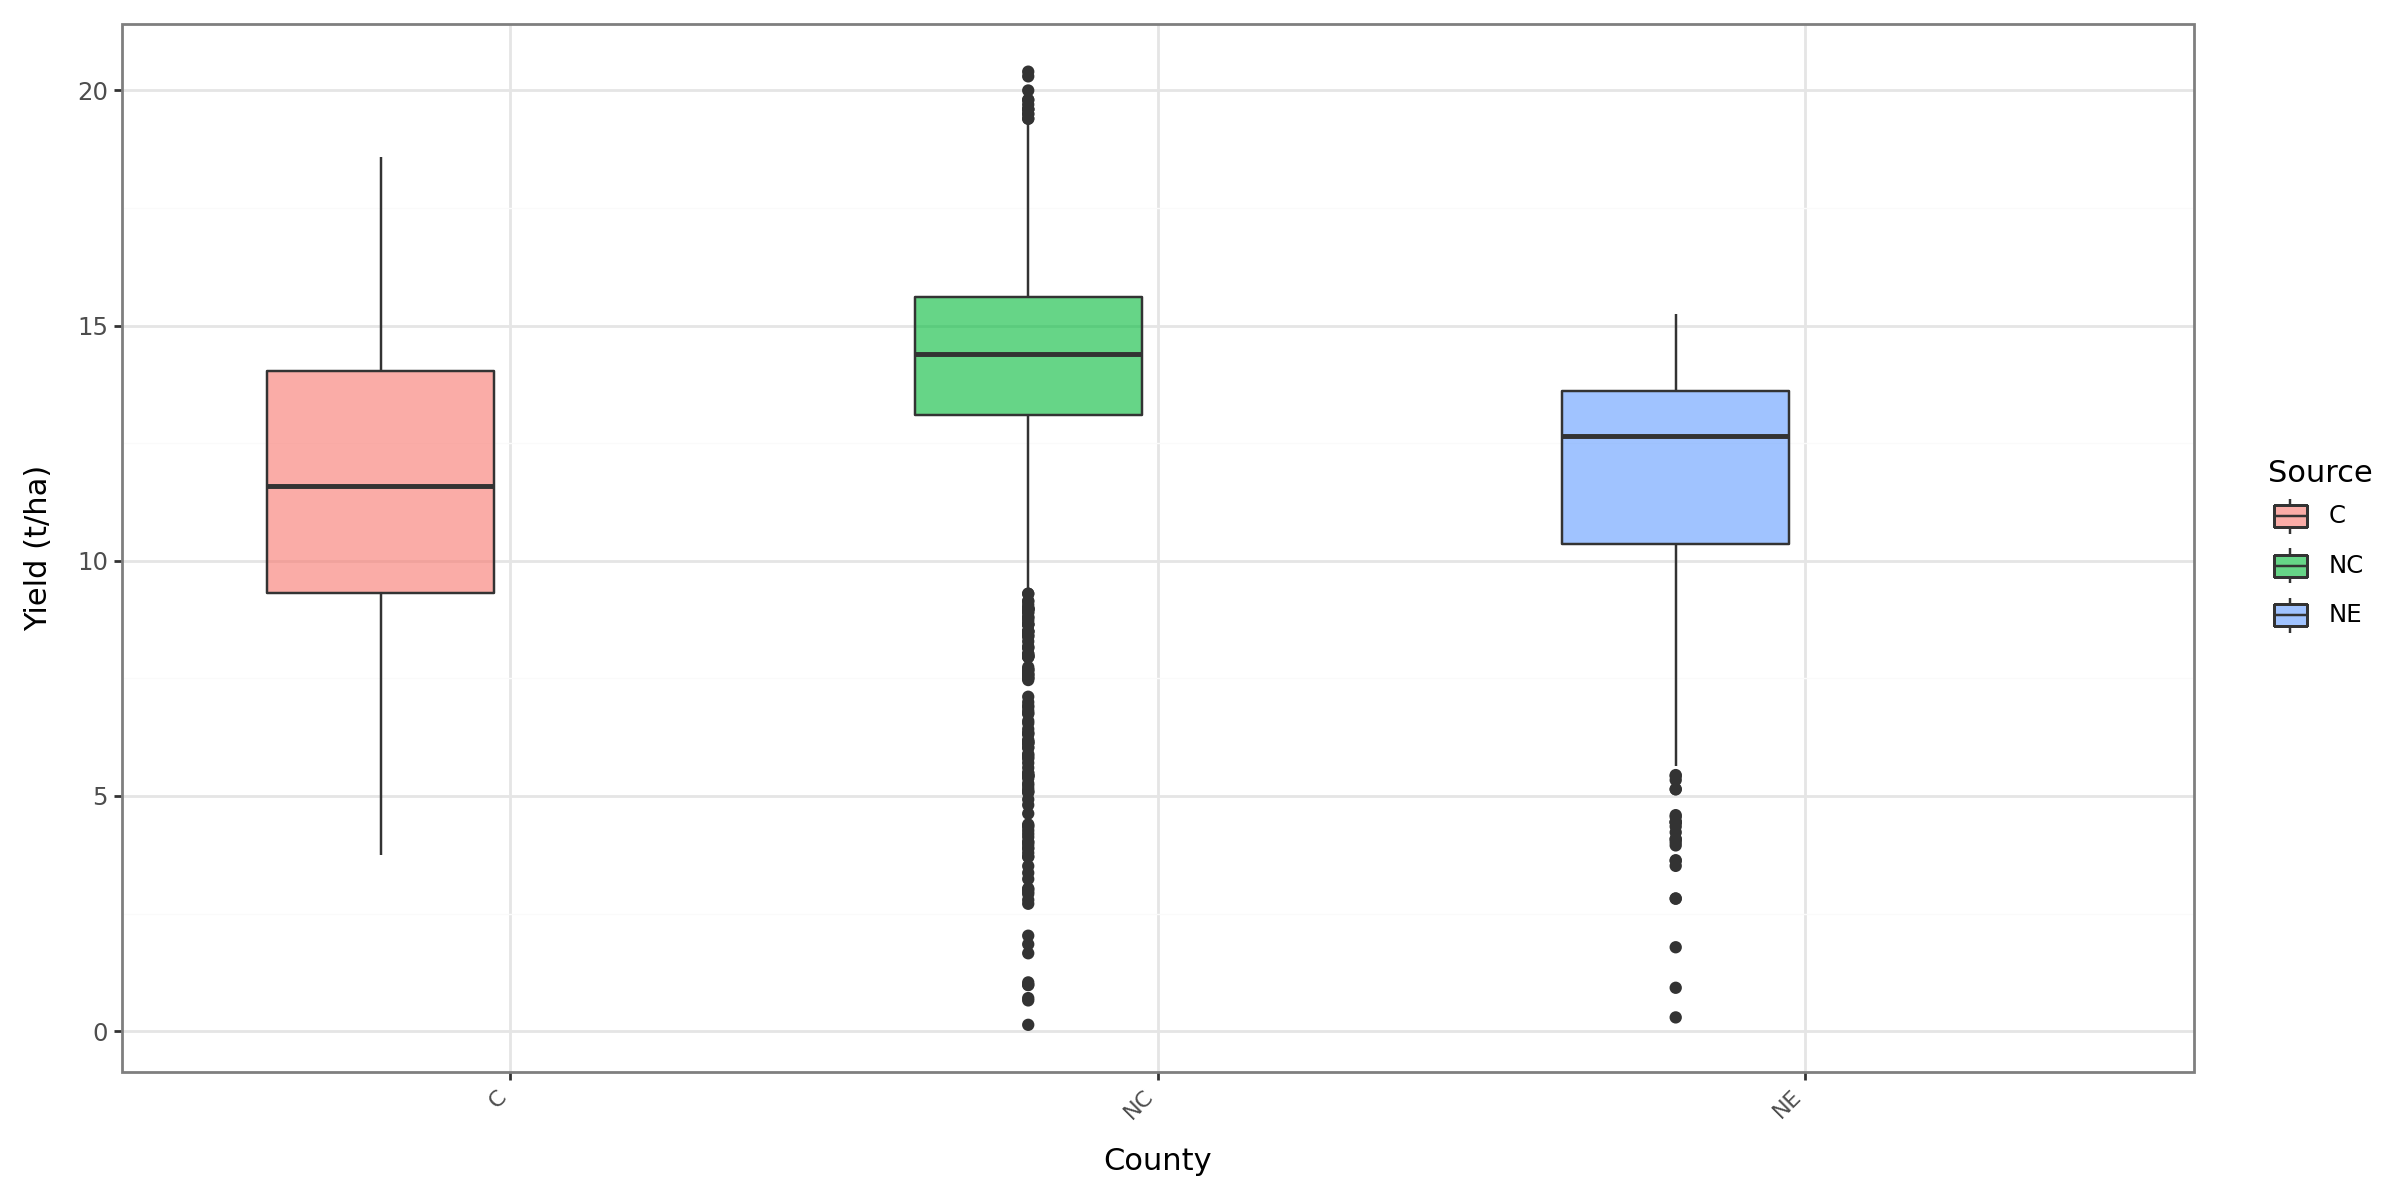

In [4]:
from plotnine import *
plot = (
    ggplot() +
    # Boxplots de valores observados
    geom_boxplot(
        data=GTD,
        mapping=aes(x='region', y='yield_ton', fill="region"),
        position=position_nudge(x=-0.2),
        width=0.35,
        alpha=0.6
    ) +
    theme_bw() +
    labs(
        x='County',
        y='Yield (t/ha)',
        fill='Source'
    )+
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),  # 🔹 tamaño y rotación
        figure_size=(12, 6)  # 🔹 hace el gráfico más ancho directamente
    )
)

plot.show()

# Comparation

In [3]:

# Loading fields 
folder = "/workspace/workflow/_3AgroDataExtraction"
geojson_file = glob.glob(os.path.join(folder, "*.geojson"))
fields=gpd.read_file(geojson_file[0])
fields_region=fields[['id_cell','id_within_cell','region']]
fields_region_indexed = fields_region.set_index(['id_cell', 'id_within_cell'])
# Extracting the year

fields_region_indexed


,,region
id_cell,id_within_cell,
0,2,NC
1,2,NC
2,2,NC
3,2,NC
45,2,NC
...,...,...
1295,2,NE
1296,2,NE
1297,2,NE


In [ ]:
# Preparation simulated data
results = pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet", engine="fastparquet")
results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])
results['year'] = results['Clock.Today'].dt.year
# Yield from kg to tons
idx = results.groupby(['id_cell', 'Nitrogen','year'])['Yield'].idxmax()
results = results.loc[idx].reset_index(drop=True)
results['Yield'] = results['Yield']

# Select important variables
results = results[['id_cell','id_within_cell','Nitrogen','Yield','year','MaizeYield']]

results = results.rename(columns={
    'id': 'id_sim',
    'Year': 'year',
    'Nitrogen': 'nitrogen'
})
results_region = results.join(fields_region_indexed, on=['id_cell', 'id_within_cell'])

mask_c= (results_region['region'] == 'C') & (results_region['year'] < 2014)
# Deleting years 2019 and 2020 (No have GTD for these years)

mask_other= (results_region['region'] != 'C') & (results_region['year'] < 2019)

results_region_filtered_c= results_region[mask_c]
results_region_filtered_other= results_region[mask_other]

results_region_filtered=results_region_filtered_c.merge(results_region_filtered_other,how='outer')

# Selecting only the years where corn was produced
results_region_filtered=results_region_filtered[results_region_filtered['MaizeYield']!=0]

In [61]:
mask_GTD=(GTD['year'] < 2019) 

GTD_filtered = GTD[mask_GTD]
GTD_filtered['Yield'] = GTD_filtered['yield_ton']  

/tmp/ipykernel_41988/794231599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Merging Dataframes

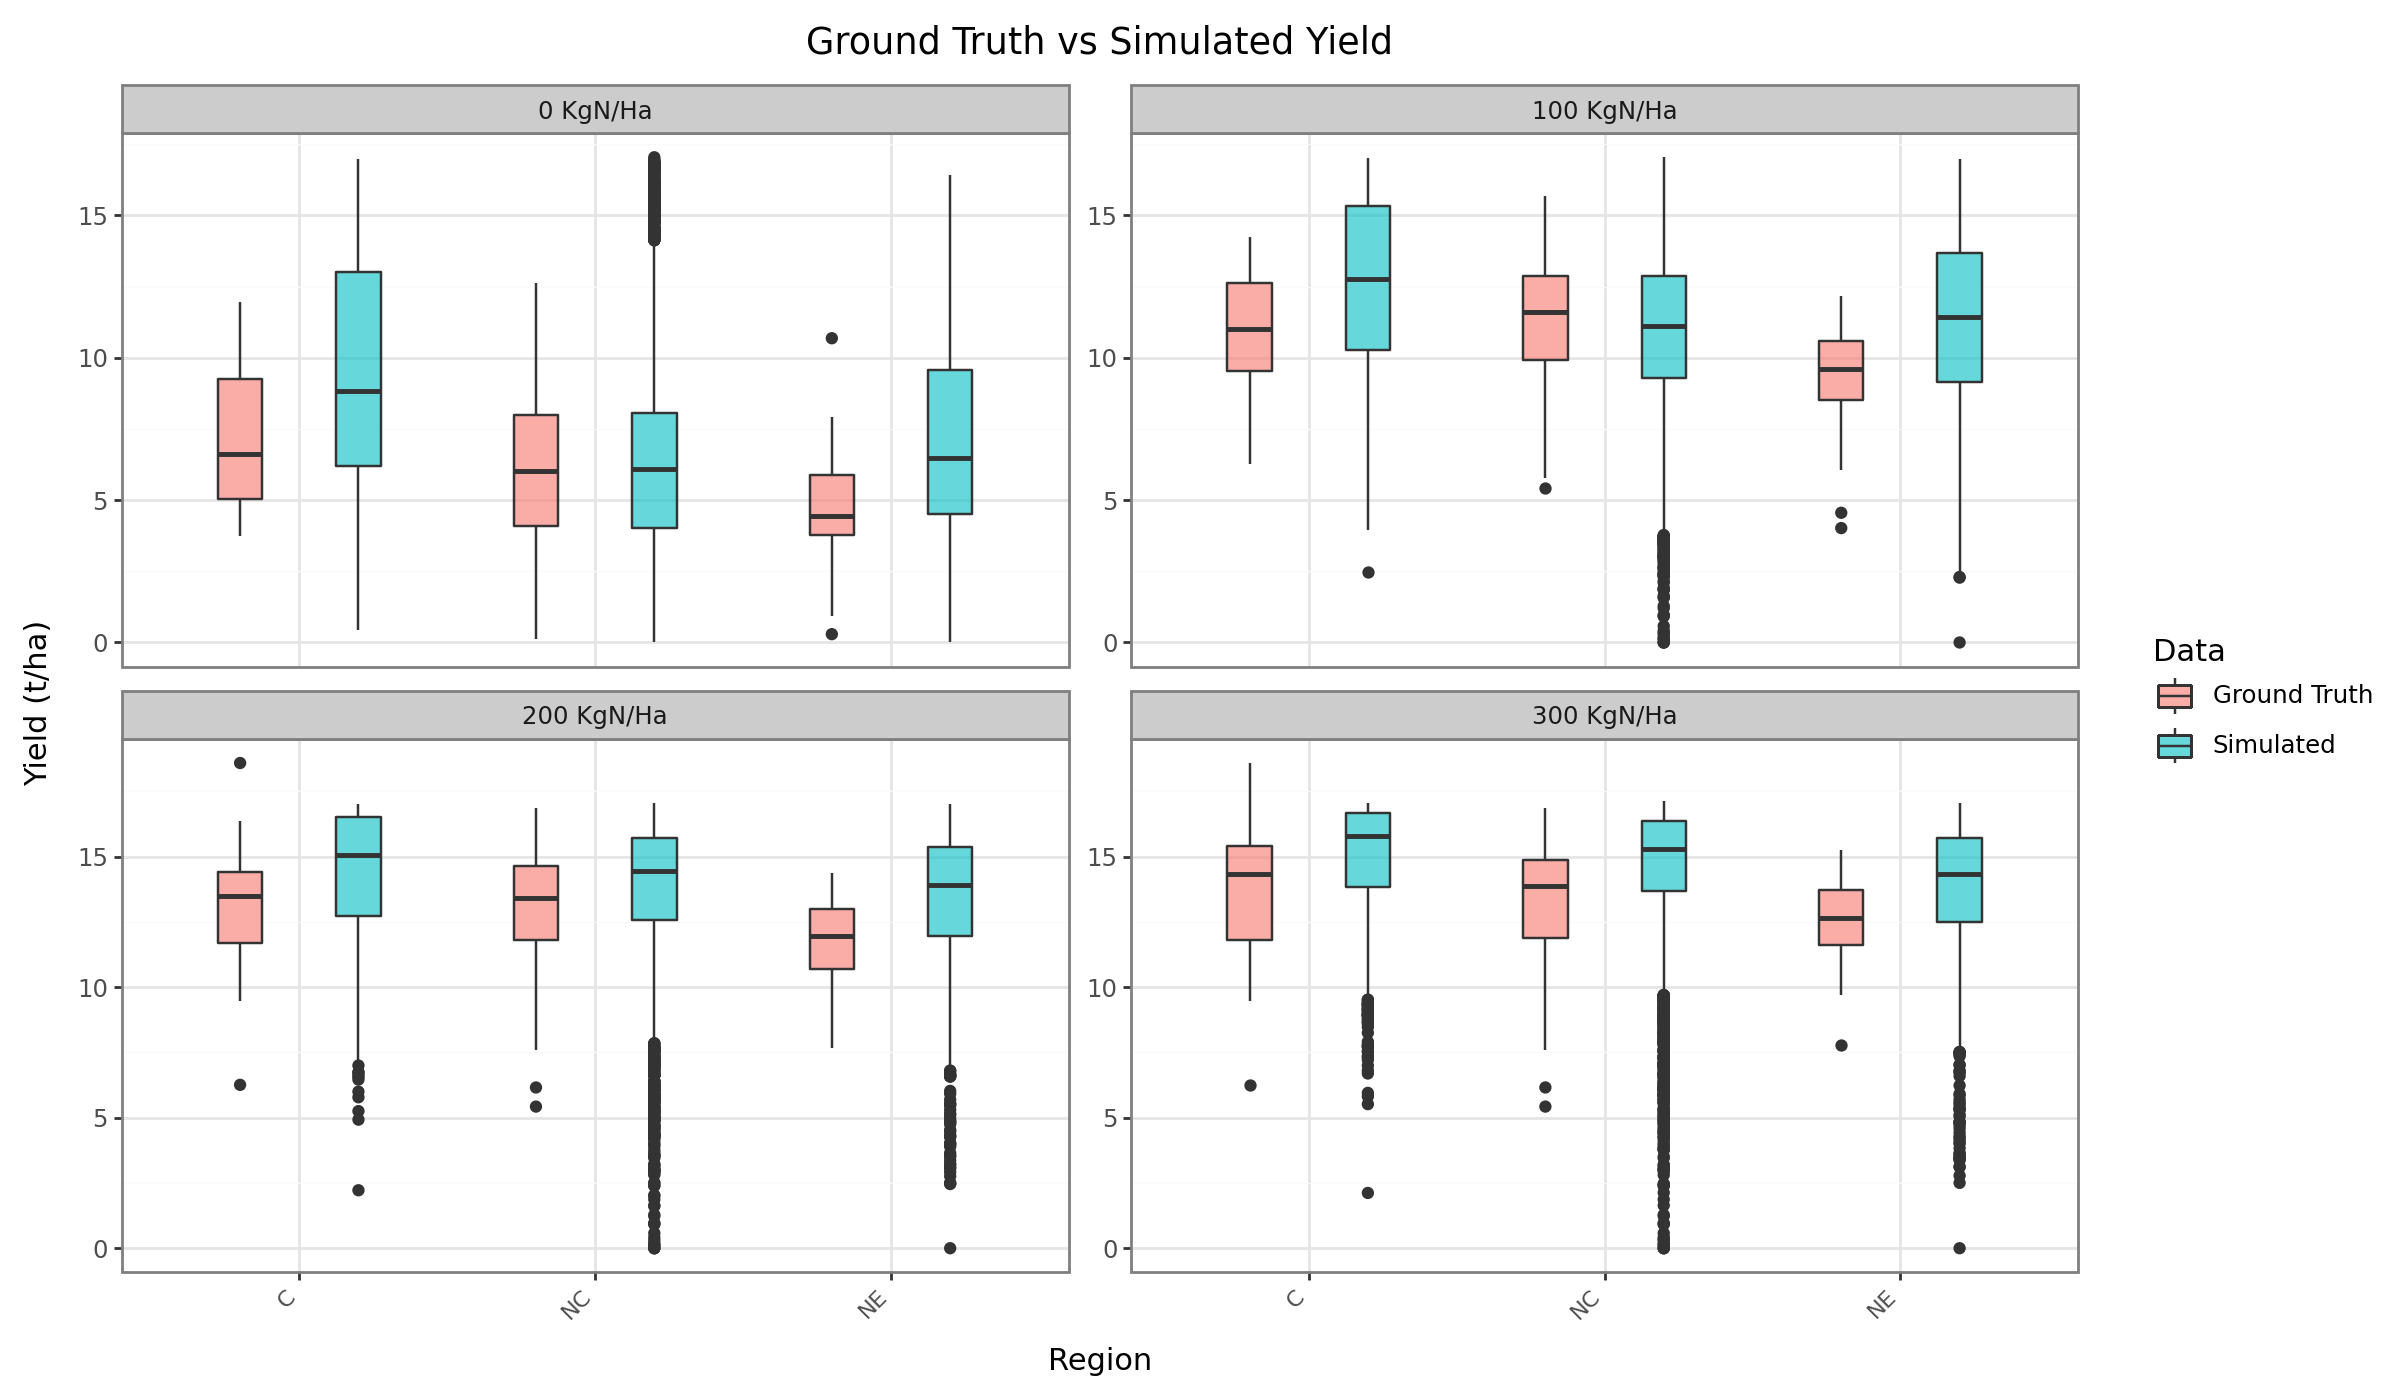

In [63]:
# Function to prepare data for a given rate
def prep_data(real, sim, rate):
    real_df = real.copy()
    real_df['Source'] = 'Ground Truth'
    real_df['Rate'] = f'{rate} KgN/Ha'
    
    sim_df = sim.copy()
    sim_df['Source'] = 'Simulated'
    sim_df['Rate'] = f'{rate} KgN/Ha'
    
    return pd.concat([real_df, sim_df], axis=0)

# Build one single dataframe with all rates
plot_data = pd.concat([
    prep_data(real0,   sim0,   0),
    prep_data(real100, sim100, 100),
    prep_data(real200, sim200, 200),
    prep_data(real300, sim300, 300)
])

plot = (
    ggplot(plot_data, aes(x='region', y='Yield', fill='Source')) +
    geom_boxplot(position=position_dodge(width=0.8), width=0.3, alpha=0.6) +
    facet_wrap('~Rate', ncol=2, scales='free_y') +
    theme_bw() +
    labs(
        title='Ground Truth vs Simulated Yield',
        x='Region',
        y='Yield (t/ha)',
        fill='Data'
    ) +
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),
        figure_size=(12, 7)
    )
)

plot


AttributeError: 'NoneType' object has no attribute 'reset_index'